In [ ]:
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflowjs as tfjs
import graphviz
import pydot
import time
from tensorflow.keras.utils import plot_model
tf.config.list_physical_devices('GPU')

In [ ]:
#global variables
stock_name = "AAPL"
stock_name_list = ["MSFT", "TSLA", "NVDA", "AAPL"]
start_year = 2014
end_year = 2024
day_before = 60
predict_day = 60
start_index = 0
sc = MinMaxScaler(feature_range=(0,1))
pwd = os.getcwd()

In [ ]:
#common functions
def load_dataframe(**kwargs):
    stock_name = kwargs["stock_name"]
    start_year = kwargs["start_year"]
    end_year = kwargs["end_year"]
    df = yf.download(stock_name, start=f'{start_year}-01-01', end=f'{end_year}-01-01')
    #df = pd.read_csv(f'./stocks/{name}.csv') # Default load local csv file
    return df

def get_X_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs["day_before"]
    end_index = len(df)
    X_train = df.iloc[start_index:end_index, 0:1].values #open price
    X_train = sc.fit_transform(X_train)
    X_train = [X_train[i-day_before:i, 0] for i in range(day_before, len(X_train))]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train

def get_X_test(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs["day_before"]
    predict_day = kwargs["predict_day"]
    end_index = len(df)
    start_index = start_index - day_before - predict_day
    X_test = df.iloc[start_index:end_index, 0:1].values #open price
    X_test = sc.fit_transform(X_test)
    X_test = [X_test[i-day_before:i, 0] for i in range(day_before, len(X_test))]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

def get_y_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    day_before = kwargs['day_before']
    end_index = len(df)
    y_train = df.iloc[start_index:end_index, -2:-1].values #close price
    y_train = sc.fit_transform(y_train)[0+day_before:end_index]
    return y_train

def get_y_test(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    predict_day = kwargs["predict_day"]
    start_index = start_index - predict_day
    end_index = len(df)
    y_test = df.iloc[start_index:end_index, -2:-1].values #close price
    return y_test

def save_model(**kwargs):
    model = kwargs["model"]
    stock_name = kwargs["stock_name"]
    model_dir = f"{pwd}\\model"
    path = f"{model_dir}\\{stock_name}\\{stock_name}.keras"
    if stock_name not in os.listdir(model_dir):
        os.mkdir(f"{model_dir}/{stock_name}")
    model.save(path)

def load_model(**kwargs):
    stock_name = kwargs["stock_name"]
    model_name = kwargs["model_name"]
    path = f"{pwd}\\model\\{stock_name}\\{model_name}"
    return tf.keras.models.load_model(path)

def convert_model_to_tfjs(**kwargs):
    stock_name = kwargs["stock_name"]
    #model = load_model(stock_name=stock_name)
    model = tf.keras.models.load_model(f"/content/model/{stock_name}/{stock_name}.keras")
    tfjs.converters.save_keras_model(model, f"/content/tfjs_model/{stock_name}")

In [ ]:
#testing metrics functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def directional_accuracy(y_true, y_pred):
    correct_direction = np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])
    return np.mean(correct_direction) * 100

def get_all_metrics(y_true, y_pred):
    metrics_object = dict()
    metrics_object["mean_absolute_error"] = mean_absolute_error(y_true, y_pred)
    metrics_object["root_mean_square_error"] = root_mean_square_error(y_true, y_pred)
    metrics_object["mean_absolute_percentage_error"] = mean_absolute_percentage_error(y_true, y_pred)
    metrics_object["r_squared"] = r_squared(y_true, y_pred)
    metrics_object["directional_accuracy"] = directional_accuracy(y_true, y_pred)
    return metrics_object

In [75]:
def get_model(**kwargs):
    X_train = kwargs['X_train']
    y_train = kwargs['y_train']
    #numpy version require 1.19.5
    #!pip install numpy==1.19.5
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.1))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.1))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.1))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0)
    return model

def train_stock_prediction_model(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_year = kwargs['start_year']
    end_year = kwargs['end_year']
    #logging
    print(f"Training {stock_name} stock prediction model")
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_year=start_year, end_year=end_year)
    #datafram size
    df_size = len(df)
    #split up training set
    X_train = get_X_train(df=df, start_index=start_index, day_before=day_before)
    y_train = get_y_train(df=df, start_index=start_index, day_before=day_before)
    #train model
    model = get_model(X_train=X_train, y_train=y_train)
    print(f"{stock_name} stock prediction model is trained")
    #saving the model
    save_model(model=model, stock_name=stock_name)
    #save_model(model=model, path=f"./model/{stock_name}")
    #return model if necessary for temporary debug
    return model

def train_set_of_stock_prediction_model(**kwargs):
    stock_name_list = kwargs['stock_name_list']
    start_year = kwargs['start_year']
    end_year = kwargs['end_year']
    model_list = []
    #iterate to train different stock prediction models
    for stock_name in stock_name_list:
        model_list.append(train_stock_prediction_model(stock_name=stock_name, start_year=start_year, end_year=end_year))
    return model_list

def plot_result(**kwargs):
    model = kwargs['model']
    stock_name = kwargs['stock_name']
    model_name = kwargs['model_name']
    predict_day = kwargs['predict_day']
    start_year = kwargs['start_year']
    end_year = kwargs['end_year']
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_year=start_year, end_year=end_year)
    #size of dataframe
    df_size = len(df)
    #testing set
    X_test = get_X_test(df=df, day_before=day_before, start_index=len(df), predict_day=predict_day)
    y_test = get_y_test(df=df, start_index=len(df), predict_day=predict_day)
    #Predicted stock price
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    #print(predicted_stock_price.shape)
    #Real stock price
    real_stock_price = y_test
    #print(real_stock_price.shape)
    # Visualising the results
    plt.figure(figsize=(16,6))
    plt.plot(df.index.values[df_size-predict_day:], real_stock_price, color = "red", label = f'Real {stock_name} Stock Price')
    plt.plot(df.index.values[df_size-predict_day:], predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{stock_name} Stock Price')
    plt.legend()
    #plt.savefig(f'./model/{stock_name}/{stock_name}.png')
    #plt.savefig(f'{pwd}\\graph\\{model_name}_{int(time.time())}.png')
    plt.savefig(f'{pwd}\\graph\\{model_name}.png')
    plt.show()
    show_testing_metrics(stock_name=stock_name, model_name=model_name, predicted_stock_price=predicted_stock_price, real_stock_price=real_stock_price)

def print_model_summary(**kwargs):
    model = kwargs['model']
    print(model.summary())
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=80,show_layer_names=True)

def show_testing_metrics(**kwargs):
    stock_name = kwargs['stock_name']
    model_name = kwargs['model_name']
    predicted_stock_price = kwargs['predicted_stock_price']
    real_stock_price = kwargs['real_stock_price']

    # Calculate metrics
    metrics_object = get_all_metrics(real_stock_price, predicted_stock_price)
    mae = metrics_object["mean_absolute_error"]
    rmse = metrics_object["root_mean_square_error"]
    mape = metrics_object["mean_absolute_percentage_error"]
    r2 = metrics_object["r_squared"]
    da = metrics_object["directional_accuracy"]
    result_string = f"""
    -----{stock_name} Testing Metrics-----
    Mean Absolute Error (MAE): {mae}
    Root Mean Square Error (RMSE): {rmse}
    Mean Absolute Percentage Error (MAPE): {mape}
    R-squared (R²): {r2}
    Directional Accuracy: {da}
    """
    # Print results
    print(result_string)

    # Save logs
    with open(f"{pwd}\\metric\\{model_name}.txt", "w") as file:
        file.write(result_string)
        file.close()

In [63]:
#model_list = train_set_of_stock_prediction_model(stock_name_list=stock_name_list, start_year=start_year, end_year=end_year)

In [ ]:
plot_result(model=model_list[1], stock_name=stock_name_list[1], predict_day=60, start_year=start_year, end_year=end_year)

In [ ]:
plot_result(model=model_list[2], stock_name=stock_name_list[2], predict_day=60, start_year=start_year, end_year=2025)

In [ ]:
def test_get_model(**kwargs):
    stock_name = kwargs["stock_name"]
    X_train = kwargs["X_train"]
    y_train = kwargs["y_train"]
    lstm_layer = kwargs["lstm_layer"]
    dense_layer = kwargs["dense_layer"]
    dropout = kwargs["dropout"]
    unit = kwargs["unit"]

    # declare model name for multiple model saving
    result_object = dict()
    model_name = f"{stock_name}_lstm_{lstm_layer}_dense_{dense_layer}_unit_{unit}"
    # log model name
    print(f"Compiling {model_name}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = unit, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.1))

    for i in range(lstm_layer):
        # Adding the LSTM layer and some Dropout regularisation iteratively
        model.add(LSTM(units = unit, return_sequences = True))
        model.add(Dropout(0.1))

    # Adding the last LSTM layer and some Dropout regularisation
    model.add(LSTM(units = unit))
    model.add(Dropout(0.1))

    for i in range(dense_layer):
    # Adding the Dense layer and some Dropout regularisation iteratively
        model.add(Dense(units = unit))
        model.add(Dropout(0.1))

    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0)
    # return model & model_name for further uses
    result_object["model_name"] = model_name
    result_object["model"] = model
    return result_object

def test_train_stock_prediction_model(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_year = kwargs['start_year']
    end_year = kwargs['end_year']
    lstm_layers = kwargs['lstm_layers']
    dense_layers = kwargs['dense_layers']
    units = kwargs['units']
    dropouts = kwargs['dropouts']
    #logging
    print(f"Training {stock_name} stock prediction model")
    #load stock historical price data of certain stock code through yahoo finance library
    df = load_dataframe(stock_name=stock_name, start_year=start_year, end_year=end_year)
    #datafram size
    df_size = len(df)
    #split up training set
    X_train = get_X_train(df=df, start_index=start_index, day_before=day_before)
    y_train = get_y_train(df=df, start_index=start_index, day_before=day_before)
    #train model
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for dropout in dropouts:
                for unit in units:
                    start_time = time.time()
                    result_object = test_get_model(
                        stock_name=stock_name,
                        X_train=X_train,
                        y_train=y_train,
                        lstm_layer=lstm_layer,
                        dense_layer=dense_layer,
                        unit=unit,
                        dropout=dropout
                    )
                    model = result_object["model"]
                    model_name = result_object["model_name"]
                    end_time = time.time()
                    print(f"{model_name} Finished: {end_time - start_time}s")
                    #saving the model
                    test_save_model(model=model, stock_name=stock_name, model_name=model_name)

def test_save_model(**kwargs):
    model = kwargs["model"]
    stock_name = kwargs["stock_name"]
    model_name = kwargs["model_name"]
    model_dir = f"{pwd}\\model"
    path = f"{model_dir}\\{stock_name}\\{model_name}.keras"
    if stock_name not in os.listdir(model_dir):
        os.mkdir(f"{model_dir}/{stock_name}")
    model.save(path)

def get_comparison_object():
    # comparison between different models
    comparison_object = dict()
    comparison_object["mean_absolute_error"] = dict()
    comparison_object["root_mean_square_error"] = dict()
    comparison_object["mean_absolute_percentage_error"] = dict()
    comparison_object["r_squared"] = dict()
    comparison_object["directional_accuracy"] = dict()
    for key in comparison_object:
        val = 0
        if key == "r_squared" or key == "directional_accuracy":
            val = -math.inf
        else:
            val = math.inf
        comparison_object[key]["val"] = val
        comparison_object[key]["name"] = ""
    return comparison_object

def test_compare_models(**kwargs):
    #arguments
    stock_name = kwargs['stock_name']
    start_year = kwargs['start_year']
    end_year = kwargs['end_year']
    predict_day = kwargs['predict_day']
    df = load_dataframe(stock_name=stock_name, start_year=start_year, end_year=end_year)
    #size of dataframe
    df_size = len(df)
    #testing set
    X_test = get_X_test(df=df, day_before=day_before, start_index=len(df), predict_day=predict_day)
    y_test = get_y_test(df=df, start_index=len(df), predict_day=predict_day)
    #Real stock price
    real_stock_price = y_test

    path = f"{pwd}\\model\\{stock_name}"
    comparison_object = get_comparison_object()
    # load trained models
    for model_name in os.listdir(path):
        # only load *.keras model
        if ".keras" not in model_name:
            continue
        model = load_model(stock_name=stock_name, model_name=model_name)
        # predicted stock price
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        metrics_object = get_all_metrics(real_stock_price, predicted_stock_price)
        for metric in metrics_object:
            val = metrics_object[metric]
            if (metric == "r_squared" or metric == "directional_accuracy") and comparison_object[metric]['val'] < val:
                comparison_object[metric]['val'] = val
                comparison_object[metric]['name'] = model_name
            elif comparison_object[metric]['val'] > val:
                comparison_object[metric]['val'] = val
                comparison_object[metric]['name'] = model_name
    for metric in comparison_object:
        print(f"({comparison_object[metric]['name']}) {metric}: {comparison_object[metric]['val']}")

In [61]:
test_train_stock_prediction_model(
    stock_name="MSFT",
    start_year=start_year,
    end_year=end_year,
    lstm_layers=[1],
    dense_layers=[1],
    units=[32,64,128],
    dropouts=[0.1]
)

Training MSFT stock prediction model
[*********************100%%**********************]  1 of 1 completed
Compiling MSFT_lstm_1_dense_1_unit_32
MSFT_lstm_1_dense_1_unit_32 Finished: 140.30057883262634s
Compiling MSFT_lstm_1_dense_1_unit_64
MSFT_lstm_1_dense_1_unit_64 Finished: 146.39174246788025s
Compiling MSFT_lstm_1_dense_1_unit_128
MSFT_lstm_1_dense_1_unit_128 Finished: 192.6451816558838s


In [ ]:
test_compare_models(stock_name="MSFT", start_year=start_year, end_year="2025", predict_day=60)

[*********************100%%**********************]  1 of 1 completed


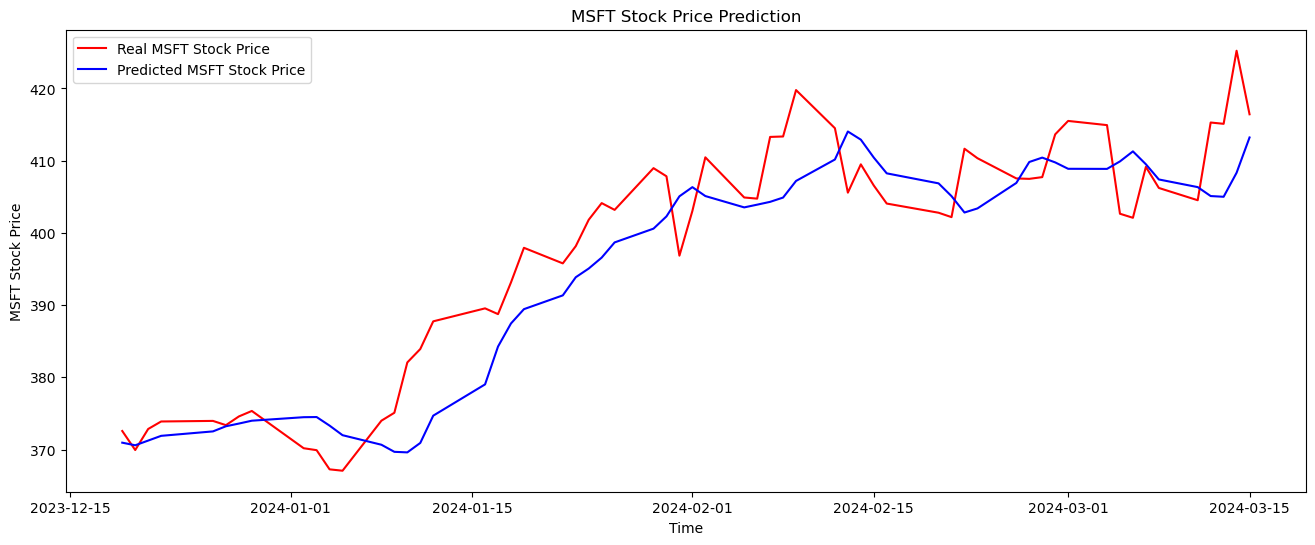


    -----MSFT Testing Metrics-----
    Mean Absolute Error (MAE): 5.4354909261067705
    Root Mean Square Error (RMSE): 6.589979849958217
    Mean Absolute Percentage Error (MAPE): 1.3580730663945737
    R-squared (R²): 0.8340987835600716
    Directional Accuracy: 54.23728813559322
    
[*********************100%%**********************]  1 of 1 completed


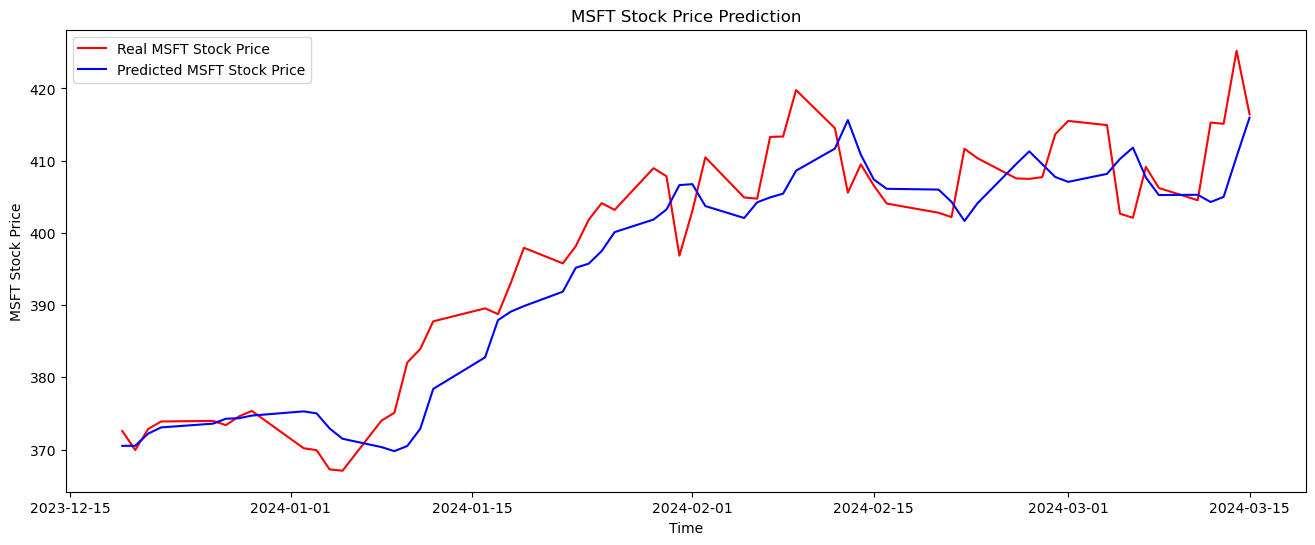


    -----MSFT Testing Metrics-----
    Mean Absolute Error (MAE): 4.946141052246094
    Root Mean Square Error (RMSE): 6.147855237992549
    Mean Absolute Percentage Error (MAPE): 1.2340199663128584
    R-squared (R²): 0.8556128106276117
    Directional Accuracy: 49.152542372881356
    
[*********************100%%**********************]  1 of 1 completed


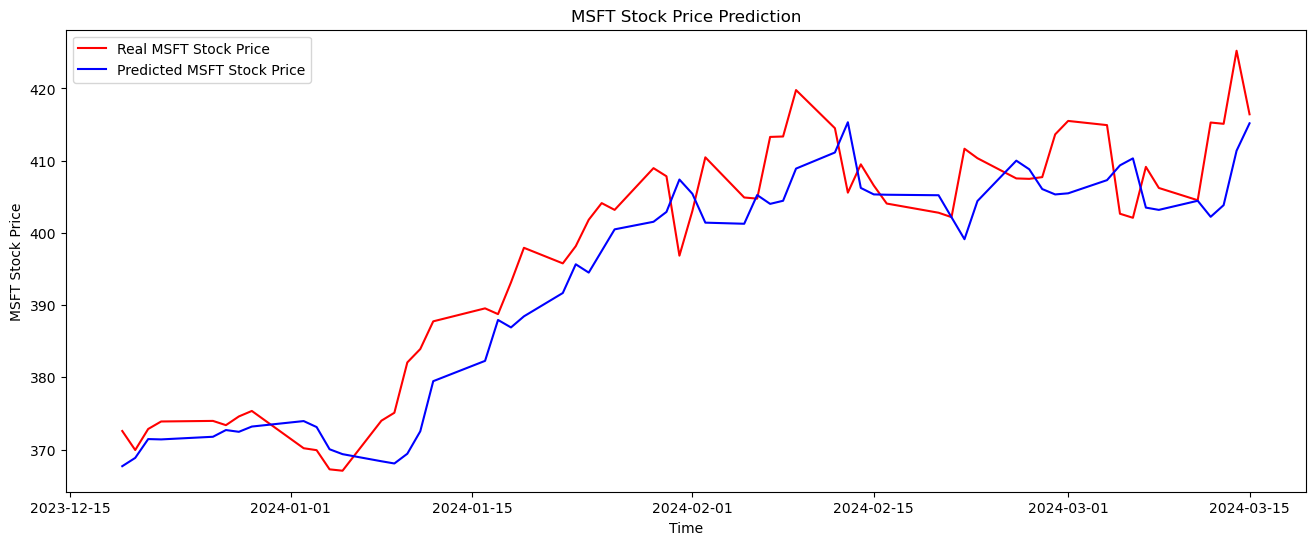


    -----MSFT Testing Metrics-----
    Mean Absolute Error (MAE): 5.379055786132812
    Root Mean Square Error (RMSE): 6.5942524557515645
    Mean Absolute Percentage Error (MAPE): 1.341560911103292
    R-squared (R²): 0.8338835900998959
    Directional Accuracy: 42.3728813559322
    


In [77]:
for i in [32, 64, 128]:
    model_name= f"MSFT_lstm_1_dense_1_unit_{i}.keras"
    test_model = load_model(stock_name="MSFT", model_name=model_name)
    plot_result(model=test_model, model_name=model_name, stock_name="MSFT", predict_day=60, start_year=start_year, end_year=2025)